## histogram_map.ipynb

This notebook is meant to test whether the transformation I deviced in 11/27/17 can in principle make arbitrary initial histograms converge onto a desired histogram after repeated applications.

The transformation is the application of the weight kernel, so the discretized Frobenius-Perron equation will be:
\begin{equation}
\rho_{n+1}(r_k) = \sum_{i=1}^M \rho_n(r_i) \delta \left[ r_k - F \left( N \sum_{j=1}^N \omega_{ss}(r_i,r_j)r_j \rho_n(r_j) \right) \right]
\end{equation}  
where $\delta$ is the discrete delta function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

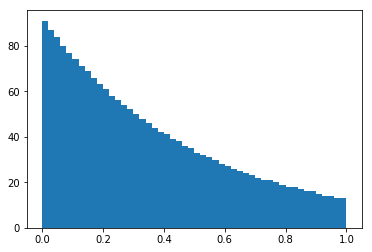

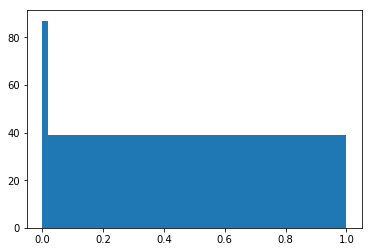

In [70]:
# Create the histograms
nbins = 50
n_units = 2000 # more units than bins
x = np.linspace(0,1,nbins+1) # bin edges
wid = x[1]-x[0]  # width of bins
bin_edges = x # a name I can remember
bin_centers = ( x + (wid/2.) )[0:-1]

# the desired histogram has an exponential shape, parameter c
c = 2.
def exp_pdf(x):
    return ( c/(1.- np.exp(-c)) )* np.exp(-c*x)
exp_hist = np.array([int(round(wid*n_units*exp_pdf(x))) for x in bin_centers])
n_units = sum(exp_hist) # the discretization changes the number of units

# the initial histogram is random
def bin_number(x):
    return int( (x-1e-7) // wid )

rho = np.zeros(nbins)
while min(rho) < 1:
    for unit in range(n_units):
        rand_bin = bin_number(np.random.rand())
        rho[rand_bin] = rho[rand_bin] + 1
        
# the initial histogram is constant
per_bin = int(n_units//nbins)
remainder = n_units%nbins
rho = np.tile(per_bin, nbins)
rho[0] += remainder

exp_fig = plt.figure()
plt.bar(bin_centers, exp_hist, wid, align='center')
init_fig = plt.figure()
plt.bar(bin_centers, rho, wid, align='center')
plt.show()

In [77]:
# Initial definitions (matching math notation)
N = n_units
rho_n = rho / N
rho_d = exp_hist / N
r = bin_centers
M = nbins
q = 1.

def F(x):
    return 1./(1.+np.exp(-x))
    
def F_inv(x):
    return np.log(x/(1.-x))
u = F_inv(r)

def eq(a,b): # utility function to see if two 1-D arrays are equal
    for ai, bi in zip(a,b):
        if ai != bi:
            return False
    return True

def w_ss(i, j, mu, rho_n): 
    """ The original weight kernel with 2-bin expansion. """
    if j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    else:
        return u[i]/mu

def w_ss2(i, j, mu, rho_n):
    """ The original weight kernel with handling of endpoint rates. """
    if i == 0 or i == 1:
        if j == i:
            clp_rho = max(1./N, rho_n[j])
            return u[i]/mu + q*( 1./rho_d[j] - 1./rho_n[j] )/N
        else:
            return u[i]/mu
    elif i == M-1 or i == M-2:
        if j == i:
            clp_rho = max(1./N, rho_n[j])
            return u[i]/mu + q*(-1./rho_d[j] + 1./rho_n[j] )/N
        else:
            return u[i]/mu
    elif j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    else:
        return u[i]/mu

def w_ss3(i, j, mu, rho_n):
    """ Weight kernel with handling of endpoint rates and control of own bin. """
    if i == 0 or i == 1:
        modif =  q*np.sign( rho_n[i] - rho_d[i] ) 
        return (u[i] + modif) / mu
    if i == M-1  or i == M-2:
        modif =  q*np.sign( rho_d[i] - rho_n[i] ) 
        return (u[i] + modif) / mu
    elif j == i-1 or j == i-2: 
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu

def w_ss4(i, j, mu, rho_n):
    """ A different kernel with handling of endpoint rates and control of own bin.
        In this one all increments/decrements are the same size. 
    """
    if i == 0 or i == 1:
        modif =  -q*np.sign( rho_n[i] - rho_d[i] ) 
        return (u[i] + modif) / mu
    if i == M-1  or i == M-2:
        modif =  q*np.sign( rho_d[i] - rho_n[i] ) 
        return (u[i] + modif) / mu
    elif j == i-1 or j == i-2: 
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu
    
def w_ss5(i, j, mu, rho_n):
    """ Weight kernel with control of own bin. """
    if j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu
    
def w_ss6(i, j, mu, rho_n):
    """ Simplest approach. """
    modif =  q*np.sign( rho_d[i] - rho_n[i] )
    return (u[i] + modif) / mu

def w_ss7(i, j, mu, rho_n):
    """ Squashing in the appropriate direction. """
    if i > 1 and i < M-1:
        modif = q*np.sign( ( (rho_n[i-1]-rho_d[i-1]) - (rho_n[i+1]-rho_d[i+1]) )*max((rho_n[i]-rho_d[i]), 0.) )
    elif i == 0:
        modif = q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    elif i == M-1:
        modif = -q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    else:
        modif = 0.
    return (u[i] + modif)/mu

def w_ss8(i, j, mu, rho_n):
    """ Difusion of density difference. """
    if i > 1 and i < M-1:
        modif = q*np.sign( ( (rho_n[i-1]-rho_d[i-1]) - (rho_n[i+1]-rho_d[i+1]) )*(rho_n[i]-rho_d[i]) )
    elif i == 0:
        modif = q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    elif i == M-1:
        modif = -q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    else:
        modif = 0.
    return (u[i] + modif)/mu

In [78]:
# Iterating
#from IPython.core.debugger import set_trace

def iterator(N, rho_n, rho_d, r, M, F, F_inv, w_ss, u, bin_number, n_iters=1):

    all_rho = np.zeros((n_iters+1,M))
    all_rho[0,:] = rho_n
    new_rho = np.zeros(M)
    #set_trace()
    for itr in range(n_iters):
        mu = sum(N * rho_n * r)
        new_count = np.zeros(M)
    
        for rate in range(M):
            tot_input = N * sum([w_ss8(rate, j, mu, rho_n)*r[j]*rho_n[j] for j in range(M)])
            act = F(tot_input)
            # instead of transfering all units from one bit to the other, we'll just move some
            in_bin = int(round(rho_n[rate]*N))
            trans = int(np.ceil(0.1*np.random.rand()*in_bin))
            #trans = int(np.ceil(0.05*in_bin))
            left = in_bin - trans
            new_count[bin_number(act)] = new_count[bin_number(act)] + trans
            
            if bin_number(act) == 0:
                print("rate %d sending %d units to %d" % (rate,trans,0))
            elif bin_number(act) == M-1:
                print("rate %d sending %d units to %d" % (rate,trans,M-1))
                
            new_count[rate] += left
            if rate == M-1:
                print("(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)")
        
        mu = sum(new_count * r)
        rho_n = new_count / N
    
        #print("this should be 1: %f" % (sum(rho_n)))
        all_rho[itr+1,:] = rho_n
        if eq(all_rho[itr,:], all_rho[itr+1,:]):
            print("Distribution converged at iteration %d" % (itr))
    return all_rho

rate 0 sending 1 units to 0
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 0 sending 4 units to 0
rate 48 sending 2 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 0 sending 1 units to 0
rate 48 sending 3 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 0 sending 4 units to 0
rate 2 sending 4 units to 0
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 0 sending 6 units to 0
rate 2 sending 3 units to 0
rate 48 sending 4 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 2 sending 3 units to 0
rate 48 sending 1 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 2 sending 1 units to 0
rate 48 sending 2 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 0 sending 8 units to 0
rate 2 sending 2 units to 0
rate 48 sending 4 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 2 sending 2 units to 0
rate 48 sending 4 units to 49
(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)
rate 2 sending 2 units

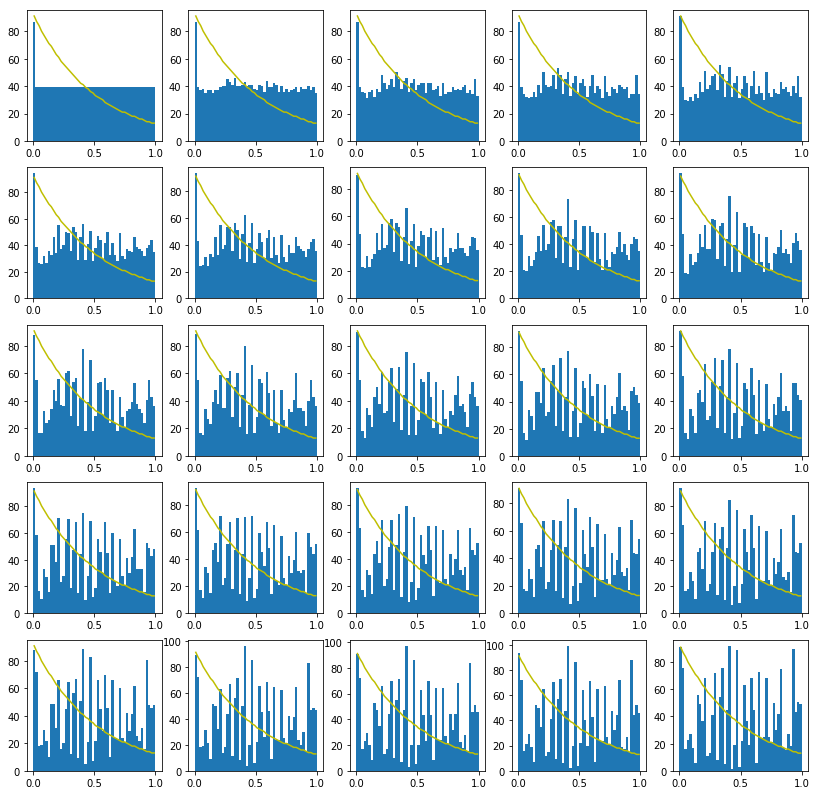

In [79]:
iters = 25
all_rho = iterator(N, rho_n, rho_d, r, M, F, F_inv, w_ss, u, bin_number, n_iters=iters)
end_fig = plt.figure(figsize=(14,14))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = end_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*all_rho[i*jump,:], wid, align='center')
    ax.plot(r, N*rho_d, 'y')
plt.show()

In [44]:
a = np.array([1,2.3,3])
b = np.array([1,2,3])

def eq(a,b):
    for ai, bi in zip(a,b):
        if ai != bi:
            return False
    return True

eq(a,b)

False

In [7]:
8 != 4

True